In [1]:
import numpy as np
import matplotlib.pyplot as plt
import paco.processing.fullpaco as f_paco
import paco.processing.paco as p
from paco.util.util import *

fp = f_paco.FullPACO(patch_size = 5)

Text(0.5, 1.0, '0 deg rotation')

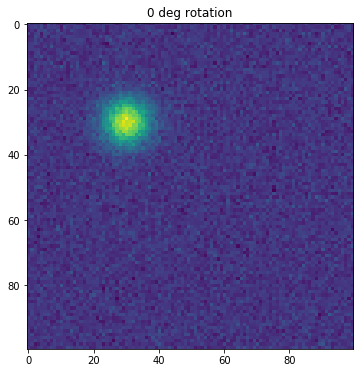

In [7]:
angles = np.array([0, 30, 45, 60, 90])
p0 = (30,30)
sigma = 0.5 # gaussian noise

mean = 0

images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(len(angles))]

xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
s = gaussian2d(xx,yy,10, 5)
images_signal = [i + s for i in images]
rot_images = np.array([rotateImage(images_signal[j], angles[j]) for j in range(len(images_signal))])
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.imshow(rot_images[0])
ax.set_title("0 deg rotation")




In [3]:
fp.im_stack = rot_images
phi0s = np.array([[30,30]])
a,b = fp.PACO(angles)
#a,b = fp.PACO_calc(phi0s,angles)
#a,b= fp.PACO(phi0s,angles)

Running PACO...
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Done


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


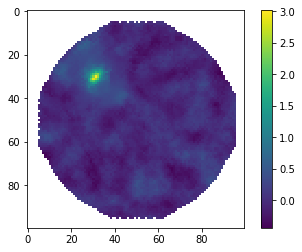

In [4]:
print(a,b)
img = b/np.sqrt(a)
plt.imshow(img)
plt.colorbar()

Notes: 

As the signal of the source increases, it pushes a_ij and b_ij towards 0
Both a and b are rotated 90 degrees from the source image.